# Index

### - Fuzzy Loss Function

### - Training a Net with FuzzyLoss (ft. pytorch_lightning)

#### a1) ResNet50

#### a2) ResNeXt50_32x4d

#### b) VGG-16

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn
import torchmetrics

from fuzzylogic.classes import Domain, Set, Rule
from fuzzylogic.hedges import very
from fuzzylogic.functions import R, S, alpha, triangular

from System import FICAR
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm

# Fuzzy Loss Function

In [7]:
# from FuzzyLoss import FuzzyLoss

class FL_FCS():
    """ Fuzzy Control System for Focal Loss """
    def __init__(self):
        # Definir dominios de inputs y output
        self.balance_deg = Domain("balance_deg", 0, 1, res=0.1)
        self.balance_deg.low = S(0.2, 0.8)
        self.balance_deg.high = R(0.2,0.8)

        self.loss_tminus = Domain("loss_tminus", 0, 2, res=0.01)
        self.loss_tminus.low = S(0.25, 1.75)
        self.loss_tminus.med = triangular(0.25, 1.75, c=1.0)
        self.loss_tminus.high = R(0.25,1.85)

        self.delta_gamma = Domain("Delta_gamma", -0.2, 0.2, res=0.01)
        self.delta_gamma.ne = S(-0.2, -0.0)
        self.delta_gamma.ze = triangular(-0.2, 0.2, c=-0.0)
        self.delta_gamma.po = R(0.0, 0.2)

        # Reglas
        R1 = Rule({(self.balance_deg.low, self.loss_tminus.low): self.delta_gamma.ne})
        R2 = Rule({(self.balance_deg.low, self.loss_tminus.med): self.delta_gamma.ne})
        R3 = Rule({(self.balance_deg.low, self.loss_tminus.high): self.delta_gamma.ze})
        R4 = Rule({(self.balance_deg.high, self.loss_tminus.low): self.delta_gamma.ze})
        R5 = Rule({(self.balance_deg.high, self.loss_tminus.med): self.delta_gamma.po})
        R6 = Rule({(self.balance_deg.high, self.loss_tminus.high): self.delta_gamma.po})
        self.rules = R1 | R2 | R3 | R4 | R5 | R6
    
    def evaluate(self, bd, lt):
        """ return how much to change current gamma in terms of:
            - current class' balance degree
            - current focal loss for current class, obtained during step
        """
        values = {self.balance_deg: bd, self.loss_tminus: lt}
        delta_gamma = self.rules(values)
        return delta_gamma

    
class FuzzyLoss(torch.nn.CrossEntropyLoss):
    """ Fuzzy-Adaptive Focal Loss
    
    gamma in [0, +inf)
    alpha in [0, 1]
    """
    def __init__(self, gamma=0, class_sizes=[1,1], alpha=None):
        super(FuzzyLoss, self).__init__()
        
        self.class_sizes = np.array(class_sizes)
        self.n_classes = len(self.class_sizes)
        # balance degree of each class (size_i / max(size_j))
        self.balance_deg = dict((i, class_sizes[i]/max(class_sizes)) for i in range(len(class_sizes)))
        
        # initially all classes with same gamma
        self.gamma = dict((i, gamma) for i in range(self.n_classes))
        self.alpha = alpha
        
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        
        self.FCS = FL_FCS()

    def forward(self, input_, target):
        if input_.dim()>2:
            input_ = input_.view(input_.size(0),input_.size(1),-1)  # N,C,H,W => N,C,H*W
            input_ = input_.transpose(1,2)    # N,C,H*W => N,H*W,C
            input_ = input_.contiguous().view(-1,input_.size(2))   # N,H*W,C => N*H*W,C
        ground_truth = target
        target = target.view(-1,1)

        logpt = F.log_softmax(input_, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = logpt.data.exp()

        if self.alpha is not None:
            if self.alpha.type()!=input_.data.type():
                self.alpha = self.alpha.type_as(input_.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)
        
        loss = torch.Tensor([0.0]*len(pt))
        for i, (pt_, logpt_) in enumerate(zip(pt, logpt)):
            curr_class = ground_truth[i].item()
            # la loss de cada instancia del batch evaluada con su gamma respectiva
            loss[i] = -1 * (1-pt_)**self.gamma[curr_class] * logpt_
        
        # tanto la media como el loss para cada _Instancia_
        return loss.mean(), loss
        
    def update_hyperparams(self, current_losses, targets, alpha=None):
        """ update each class' gamma based on:
            - that class's balance degree
            - that class's loss in current step
        """
        if alpha is not None:
            self.alpha = alpha
        if len(current_losses) != len(targets):
            raise ValueError('current loss must be same length as targets!')
        
        # obtener loss media para cada clase
        class_loss = {}
        targets = targets.cpu().numpy()
        for i in range(len(targets)):
            if targets[i] not in class_loss:
                class_loss[targets[i]] = np.array([current_losses[i].item()])
            else:
                class_loss[targets[i]] = np.append(class_loss[targets[i]], current_losses[i].item())
        for k in class_loss.keys():
            class_loss[k] = class_loss[k].mean()
        
        for i in range(self.n_classes):
            try:
                delta_gamma = self.FCS.evaluate(self.balance_deg[i], class_loss[i])
            except:
                delta_gamma = 0
            self.gamma[i] += delta_gamma
            self.gamma[i] = max(self.gamma[i], 0) # enforce gamma >= 0

In [3]:
y_true = torch.tensor([0,  1], dtype=torch.int64)
y_pred = torch.tensor([[.7 , 0 , 0 ,0 ,  .3], [0, 0.9, 0, 0.1, 0]])

print('DF-CELoss : ', torch.nn.CrossEntropyLoss()(y_pred, y_true).numpy())

fuzzyloss = FuzzyLoss(gamma=0., class_sizes=[500,5000])
loss, losses = fuzzyloss(y_pred, y_true)
print('FuzzyLoss : ', loss.numpy())
fuzzyloss.update_hyperparams(losses, y_true)
print('FuzzyLoss : ', loss.numpy())

DF-CELoss :  1.0661571
FuzzyLoss :  1.0661571
FuzzyLoss :  1.0661571


# Training a Net with FuzzyLoss (ft. `pytorch_lightning`)

## a1) ResNet50

In [ ]:
from System import get_dataloaders_from_path, plot_images_sample

dataloaders, dataset_sizes, class_names = get_dataloaders_from_path('../data/PlantVillage/')
plot_images_sample(dataloaders['train'])
print('NTrain:', len(dataloaders['train'])*32, '// NVal:', len(dataloaders['val'])*32) # 32-img batches

In [88]:
from torchvision.models import resnet50

EPOCHS = 200
mean_losses = []
mean_acc = []
mean_f1s = []

class ResNetCustom(pl.LightningModule):
    def __init__(self, gamma=0., class_sizes=[1,1]):
        super().__init__()
        self.n_classes = len(class_sizes)
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
        self.fuzzyloss = FuzzyLoss(gamma=gamma, class_sizes=class_sizes).cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
        mean_loss, losses = self.fuzzyloss(logits, y)
        mean_losses.append(mean_loss)
        
        # Update focal loss with Fuzzy Control System
#         self.fuzzyloss.update_hyperparams(losses, y)
        return mean_loss
    
    def configure_optimizers(self):
#         return torch.optim.RMSprop(self.parameters(), lr=0.005)
#         return torch.optim.SGD(self.model[0].fc.parameters(), lr=0.001, momentum=0.9)
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=1e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=len(dataloaders['train']),
                                epochs=EPOCHS)
        }

In [ ]:
model = ResNetCustom(gamma=0., class_sizes=[1591,373])
trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, devices=1, accelerator="gpu")
trainer.fit(model, dataloaders['train'])

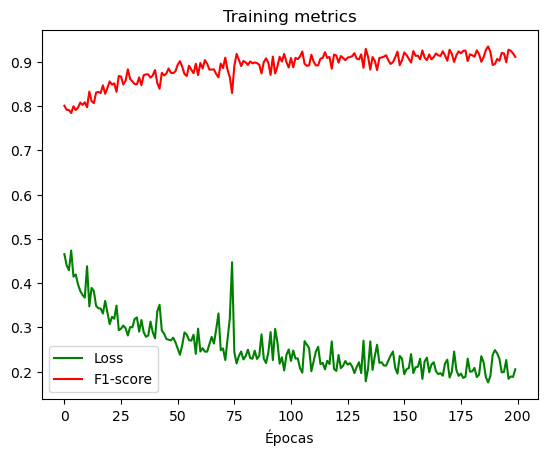

In [90]:
# Plot mean loss
x_axis = [i for i in range(200)]

splits=49
plt.plot(x_axis, [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)], 'g', label='Loss')
# plt.plot(x_axis, [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)], 'b', label='n')
plt.plot(x_axis, [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)], 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()

In [91]:
trainer.save_checkpoint("saves/resnet50_PlantVillage_focalloss_transfer.pt")

Now we can reload it w/o training:

In [92]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

inference_model = ResNetCustom.load_from_checkpoint("saves/resnet50_PlantVillage_focalloss_transfer.pt", map_location="cuda", gamma=0., class_sizes=[1,1])

In [93]:
from tqdm.autonotebook import tqdm

true_y, pred_y = [], []
for batch in tqdm(iter(dataloaders['val']), total=len(dataloaders['val'])):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, inference_model)
    pred_y.extend(preds.cpu())

  0%|          | 0/13 [00:00<?, ?it/s]

In [94]:
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.978     0.972     0.975       326
           1      0.892     0.914     0.902        81

    accuracy                          0.961       407
   macro avg      0.935     0.943     0.939       407
weighted avg      0.961     0.961     0.961       407



## a2) ResNet50 + transfer learning + 5-Fold

In [4]:
data_transforms = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset = datasets.ImageFolder('../data/PlantVillage/train',data_transforms)

In [5]:
from torchvision.models import resnet50

mean_losses = []
mean_acc = []
mean_f1s = []

class ResNetCustom(pl.LightningModule):
    def __init__(self,
                 gamma=0.,
                 class_sizes=[1,1],
        ):
        super().__init__()
        self.n_classes = len(class_sizes)
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
        self.fuzzyloss = FuzzyLoss(gamma=gamma, class_sizes=class_sizes).cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
        mean_loss, losses = self.fuzzyloss(logits, y)
        mean_losses.append(mean_loss)
        
        # Update focal loss with Fuzzy Control System
        self.fuzzyloss.update_hyperparams(losses, y)
        return mean_loss
    
    def configure_optimizers(self):
#         return torch.optim.RMSprop(self.parameters(), lr=0.005)
#         return torch.optim.SGD(self.model[0].fc.parameters(), lr=0.001, momentum=0.9)
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=1e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=len(trainloader),
                                epochs=EPOCHS)
        }

In [8]:
EPOCHS=20
K=5
GAMMA_0=2

def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

kfold = KFold(n_splits=K, shuffle=True)
for fold,(train_idx,val_idx) in enumerate(kfold.split(image_dataset)):
    print(f'------------fold nº {fold}----------------------')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    trainloader = torch.utils.data.DataLoader(
                      image_dataset, 
                      batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      image_dataset,
                      batch_size=10, sampler=val_subsampler)
    
    # Train this fold
    model = ResNetCustom(gamma=GAMMA_0, class_sizes=[1591,373])
    trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, devices=1, accelerator="gpu")
    trainer.fit(model, trainloader)
    
    # Test this fold
    true_y, pred_y = [], []
    for batch in tqdm(iter(testloader), total=len(testloader)):
        x, y = batch
        true_y.extend(y)
        preds, probs = get_prediction(x, model)
        pred_y.extend(preds.cpu())
    
    print(classification_report(true_y, pred_y, digits=3))

------------fold nº 0----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.997     0.997     0.997       328
           1      0.985     0.985     0.985        65

    accuracy                          0.995       393
   macro avg      0.991     0.991     0.991       393
weighted avg      0.995     0.995     0.995       393

------------fold nº 1----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.997     0.997     0.997       321
           1      0.986     0.986     0.986        72

    accuracy                          0.995       393
   macro avg      0.991     0.991     0.991       393
weighted avg      0.995     0.995     0.995       393

------------fold nº 2----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.997     1.000     0.998       322
           1      1.000     0.986     0.993        71

    accuracy                          0.997       393
   macro avg      0.998     0.993     0.996       393
weighted avg      0.997     0.997     0.997       393

------------fold nº 3----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.994     1.000     0.997       312
           1      1.000     0.975     0.988        81

    accuracy                          0.995       393
   macro avg      0.997     0.988     0.992       393
weighted avg      0.995     0.995     0.995       393

------------fold nº 4----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | f1score   | BinaryF1Score  | 0

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.997     0.994     0.995       308
           1      0.976     0.988     0.982        84

    accuracy                          0.992       392
   macro avg      0.987     0.991     0.989       392
weighted avg      0.992     0.992     0.992       392



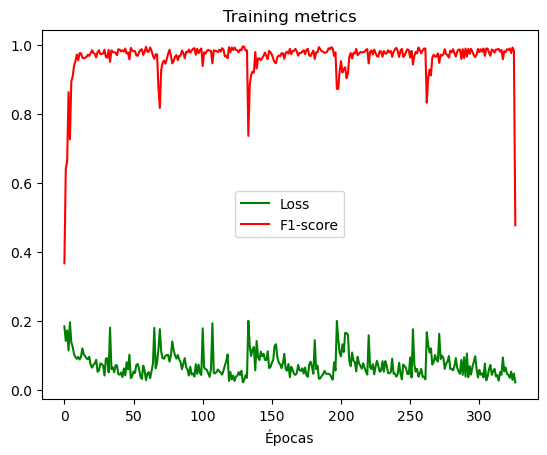

In [10]:
# Plot mean loss
x_axis = [i for i in range(327)]

splits=49
plt.plot(x_axis, [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)], 'g', label='Loss')
# plt.plot(x_axis, [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)], 'b', label='n')
plt.plot(x_axis, [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)], 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()

## b) VGG-16

In [6]:
from torchvision.models import vgg16

class VGGCustom(pl.LightningModule):
    def __init__(self, gamma=0., class_sizes=[]):
        super().__init__()
        self.model = vgg16(num_classes=10)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.loss = FuzzyLoss(gamma=gamma, class_sizes=class_sizes)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.005)

In [7]:
model2 = VGGCustom(gamma=0., class_sizes=[1,1])
trainer2 = pl.Trainer(gpus=1, max_epochs=5, devices=1, accelerator="gpu")
trainer2.fit(model2, dataloaders['train'])

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | VGG       | 134 M 
1 | loss  | FuzzyLoss | 0     
------------------------------

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [8]:
trainer2.save_checkpoint("saves/vgg16_utk_focalloss.pt")

In [9]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

inference_model = VGGCustom.load_from_checkpoint("saves/vgg16_utk_focalloss.pt", map_location="cuda", gamma=0., class_sizes=[1,1])

from tqdm.autonotebook import tqdm
true_y, pred_y = [], []
for batch in tqdm(iter(dataloaders['val']), total=len(dataloaders['val'])):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, inference_model)
    pred_y.extend(preds.cpu())
    
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))

  0%|          | 0/220 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.516     1.000     0.680      3621
           1      0.000     0.000     0.000      3401

    accuracy                          0.516      7022
   macro avg      0.258     0.500     0.340      7022
weighted avg      0.266     0.516     0.351      7022



/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## c) 